In [0]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
cd gdrive/Shared drives/group5/numpy

In [0]:
import os
from PIL import Image
import numpy as np
import pandas as pd
from sklearn import datasets, model_selection
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
# train set load

with np.load('./new_total_train_X.npz') as data:
    X_train = data['arr_0']

with np.load('./new_total_train_Y.npz') as data:
    Y_train = data['arr_0']
    
X_train = torch.from_numpy(X_train).float()
Y_train = torch.from_numpy(Y_train).long()

train = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train, batch_size=64, shuffle=True)

In [0]:
# validation set load

with np.load('./val_X.npz') as data:
    X_val = data['arr_0']

with np.load('./val_Y.npz') as data:
    Y_val = data['arr_0']

X_val = torch.from_numpy(X_val).float()
Y_val = torch.from_numpy(Y_val).long()

val = TensorDataset(X_val, Y_val)
val_loader = DataLoader(val, batch_size=64, shuffle=True)

In [0]:
# test set load

with np.load('./test_X.npz') as data:
    X_test = data['arr_0']

with np.load('./test_Y.npz') as data:
    Y_test = data['arr_0']

X_test = torch.from_numpy(X_test).float()
Y_test = torch.from_numpy(Y_test).long()

test = TensorDataset(X_test, Y_test)
test_loader = DataLoader(test, batch_size=64, shuffle=True)

In [0]:
# 2 layer CNN

import torch.nn as nn

# 신경망 구성
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    # 합성곱층
    self.conv1 = nn.Conv2d(3, 10, 5) # 입력 채널 수, 출력 채널 수, 필터 크기
    self.conv2 = nn.Conv2d(10, 20, 5)

    # 전결합층
    self.fc1 = nn.Linear(20 * 13 * 13, 50) # 13=(((((64-5)+1)/2)-5)+1)/2
    self.fc2 = nn.Linear(50, 11)

  def forward(self, x):
    # 풀링층
    x = F.max_pool2d(F.relu(self.conv1(x)), 2) # 풀링 영역 크기
    x = F.max_pool2d(F.relu(self.conv2(x)), 2)
    x = x.view(-1, 20 * 13 * 13)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return F.log_softmax(x)

# 인스턴스 생성
model = Net()

In [0]:
# parameter setting

import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [0]:
# train 

train_loss = []
validation_loss = []

for epoch in range(10):
  total_loss = 0
  for X_train, Y_train in train_loader:
    X_train, Y_train = Variable(X_train), Variable(Y_train)
    optimizer.zero_grad()
    output = model(X_train)    
    loss = criterion(output, Y_train)
    #l2 regularization
    reg_lambda = 0.001
    l2_reg = 0.
    for param in model.parameters():
      l2_reg += param.norm(2)  
    loss = loss + reg_lambda * l2_reg
    # back propagation
    loss.backward()
    # weight update
    optimizer.step()
    total_loss += loss.data.item()

  # validation loss
  with torch.no_grad():
    val_loss = 0.0
    for i, val in enumerate(val_loader,0):
      X_val, Y_val = val
      val_output = model(X_val)
      v_loss = criterion(val_output, Y_val)
      val_loss += v_loss  
      del v_loss
      del val_output
      #l2 regularization
      reg_lambda = 0.001
      l2_reg = 0.
      for param in model.parameters():
        l2_reg += param.norm(2)  
      val_loss = val_loss + reg_lambda * l2_reg

  # print loss, val_loss
  j = len(train_loader)
  i = len(val_loader)
  print('[%d] loss: %.5f   val_loss: %.5f' %(epoch+1, total_loss/(j+1), val_loss/(i+1)))
  train_loss.append(total_loss/(j+1))
  validation_loss.append(val_loss/(i+1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


[1] loss: 2.32702   val_loss: 2.15247
[2] loss: 2.19299   val_loss: 2.07304
[3] loss: 2.12221   val_loss: 2.03329
[4] loss: 2.07949   val_loss: 1.99760
[5] loss: 2.05384   val_loss: 1.97101
[6] loss: 2.02688   val_loss: 1.97179
[7] loss: 2.00707   val_loss: 1.96412
[8] loss: 1.98974   val_loss: 1.93839
[9] loss: 1.97161   val_loss: 1.92639
[10] loss: 1.95292   val_loss: 1.91696


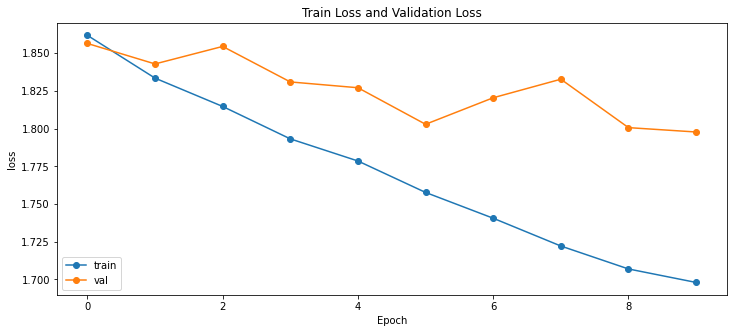

In [0]:
plt.title('Train Loss and Validation Loss')

plt.plot(train_loss, '-o', label='train')
plt.plot(validation_loss, '-o', label='val')
plt.xlabel('Epoch')
plt.ylabel('loss')

plt.legend(loc='lower left')
plt.gcf().set_size_inches(12, 5)
plt.show()

In [0]:
# test

A = np.zeros((11,11))

class_correct = list(0. for i in range(11))
class_total = list(0. for i in range(11))

with torch.no_grad():
    for k, test in enumerate(test_loader,0):
      X_test, Y_test = test
      outputs = model(X_test)
      _, predicted = torch.max(outputs, 1) # prediction
      c = (predicted == Y_test).squeeze()
      for i in range(len(predicted)):
        A[predicted[i]][Y_test[i]] += 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
# accuracy

classes = ('Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable-Fruit')

total = np.zeros((11))
correct = np.zeros((11))
correct_total = 0

prob_class = np.zeros((11,11))

for i in range(11):
  for j in range(11):
   total[j] += A[i][j]
   class_total += total[j]

for i in range(11):
  correct[i] += A[i][i]
  correct_total += correct[i]

for i in range(11):
  for j in range(11):
    prob_class[i][j] = A[i][j] / total[j]

for i in range(11):
  print('Accuracy of %5s : %2d %%' % (classes[i], 100 * correct[i] / total[i]))

print('Total Accuracy: %2d %%' % (correct_total*100 / 1644))

Accuracy of Bread : 14 %
Accuracy of Dairy product : 22 %
Accuracy of Dessert : 26 %
Accuracy of   Egg : 27 %
Accuracy of Fried food : 39 %
Accuracy of  Meat : 39 %
Accuracy of Noodles-Pasta : 43 %
Accuracy of  Rice : 38 %
Accuracy of Seafood : 26 %
Accuracy of  Soup : 63 %
Accuracy of Vegetable-Fruit : 62 %
Total Accuracy: 36 %


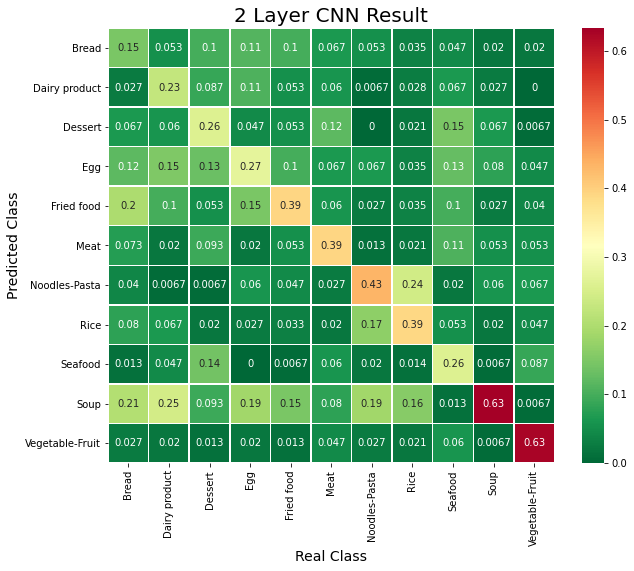

In [0]:
# heatmap

classes = ('Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable-Fruit')

plt.figure(figsize = (10,8))
sns.heatmap(prob_class, xticklabels=classes, yticklabels=classes, annot=True, cmap='RdYlGn_r', linewidths=.5)
plt.title('2 Layer CNN Result', fontsize=20)
plt.xlabel('Real Class', fontsize=14)
plt.ylabel('Predicted Class', fontsize=14)

plt.show()

In [0]:
################################ END #######################################